# Анализ данных на Python


## Обработка естественного языка. Рекуррентные нейронные сети.

В данном ноутбуке мы научимся строить рекуррентные нейронные сети и решим с помощью них 2 задачи: посимвольная генерация имен и анализ тональности текста. В генерации рассмотрим 2 варианта работы с выходами RNN. Работаем с библиотекой `torch`, а также: <a target="_blank" href="https://pytorch.org/text/main/">`torchtext`</a> и <a target="_blank" href="https://www.nltk.org/">`nltk`</a>. 

Ниже в закомментированном виде представлены все команды для установки нужных библиотек.

> Если в процессе выполнения возникает проблема с доступом к файлу `shm.dll` из пакета `torch`, необходимо внести правки в файл `__init__.py` из того расположения `torch`, которое Вы будете использовать для запуска блокнота (общая директория Python или виртуальная среда) в соответствии с этим коммитом - https://github.com/pytorch/pytorch/commit/fdfef759a676ee7a853872e347537bc1e4b51390#diff-c8835eba8562819a44e70a30545213c96e68c588a2cfa673fa495b187b1ea8df

In [1]:
# %pip install portalocker

# %pip install pip setuptools wheel
# %pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !python -m spacy download ru_core_news_sm

# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install torchinfo
# %pip install torchdata
# %pip install scikit-learn
# %pip install torchtext

# %pip install nltk

Импорт библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from random import sample

import torch
torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torchtext
from torchtext import data, datasets
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

import nltk
from nltk.corpus import names as names_data
from string import punctuation

sns.set(palette="Set2")
sns.set_style("whitegrid")

# Загрузим необходимые датасеты nltk
nltk.download("names")
nltk.download("stopwords")

print(f"torchtext version: {torchtext.version}")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

C:\Users\Killroy\AppData\Roaming\Python\Python312\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Killroy\AppData\Roaming\Python\Python312\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Killroy\AppData\Roaming\nltk_dat

torchtext version: <module 'torchtext.version' from 'C:\\Users\\Killroy\\AppData\\Roaming\\Python\\Python312\\site-packages\\torchtext\\version.py'>
cuda


На всякий случай проверим, что импортировалась устанавливаемая версия торча - последняя актуальная версия с CUDA

In [3]:
print(torch.__version__)

2.3.0+cu121


## 1. Параметры и применение RNN

Вспомним, какие гиперпараметры есть у рекуррентного слоя.

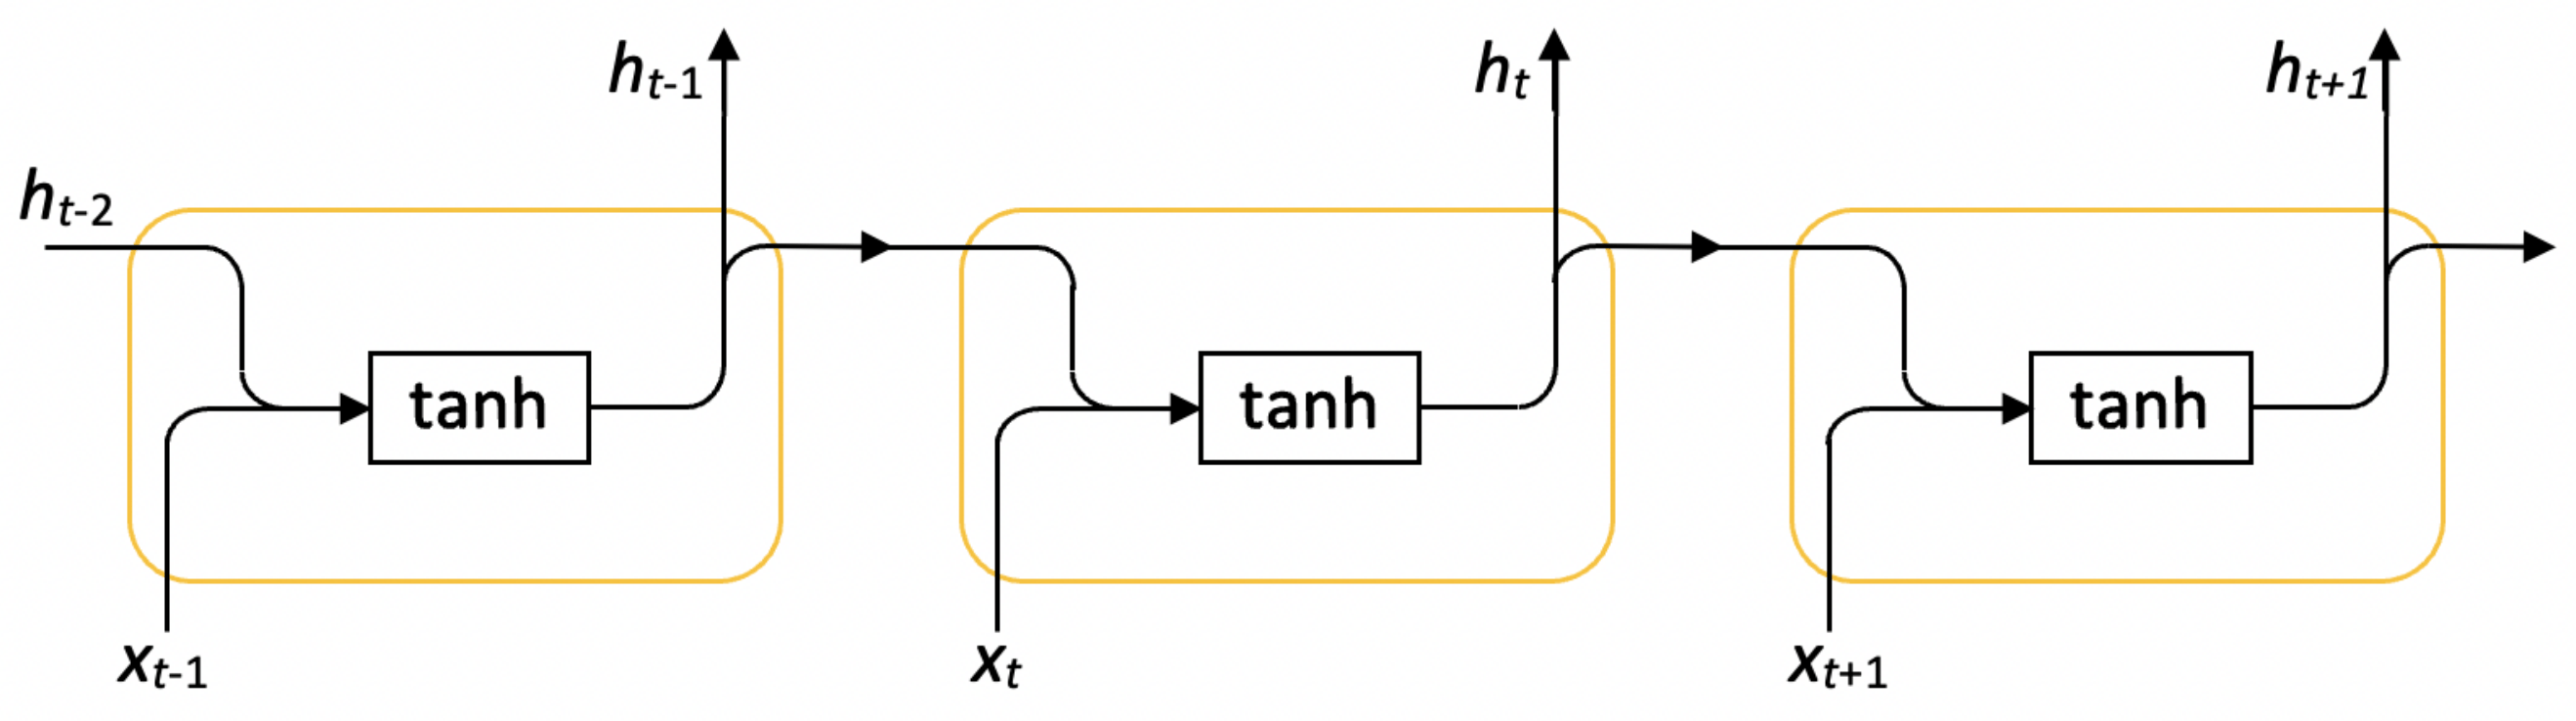

#### Классическая RNN (Vanilla RNN)

Принимает на вход очередной токен $x_t$ и предыдущее скрытое состояние $h_{t-1}$ и выдаёт новое скрытое состояние $h_t$.
Преобразование происходит по формуле:

$$h_t = \sigma(U_hx_t + V_hh_{t-1} + b_h),$$

где
* $x_{t}$ &mdash; токен: `[emb_dim, 1]`;

* $h_t$ &mdash; скрытое состояние: `[hid_dim, 1]`;

* $b_h$ &mdash; обучаемый вектор сдвига: `[hid_dim, 1]`;

* $U_h$ &mdash; обучаемая матрица для преобразования входов: `[emb_dim, hid_dim]`;

* $V_h$ &mdash; обучаемая матрица для преобразования скрытого состояния: `[hid_dim, hid_dim]`;

* $\sigma$ &mdash; нелинейная функция, по умолчанию `tanh`.

$U_h, V_h, b_h, W_y, b_y$ &mdash; обучаемые параметры RNN-клетки, а `hid_dim`, `emb_dim` &mdash; гиперпараметры.

Если же мы хотим решать задачу классификации, то мы можем применить линейный слой с функций softmax к скрытому состоянию и получить предсказание вероятности:
$$o_t = \sigma(W_o h_t + b_o).$$

В модуле `torch.nn` клетка Vanilla RNN представлена классом <a target="_blank" href="https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html">`torch.nn.RNNCell`</a>. Его можноинициализировать следующим образом:

> `torch.nn.RNNCell(input_size: int, hidden_size: int, bias: bool = True, nonlinearity: str = 'tanh')`.

Класс `RNNCell` возвращает только следующее скрытое состояние $h_t$.

Самый простой пример применения клетки RNN:

In [4]:
seq_len = 6

rnn = nn.RNNCell(input_size=10, hidden_size=20)
input = torch.randn(seq_len, 3, 10)
hx = torch.randn(3, 20)

for i in range(seq_len):
    hx = rnn(input[i], hx)
print(hx)
print(hx.shape)

tensor([[-0.3360, -0.0659, -0.5899, -0.3887,  0.2561,  0.7709, -0.1470, -0.2173,
          0.1034, -0.0617,  0.5807,  0.0026,  0.1800, -0.0446,  0.1820,  0.0713,
         -0.3067, -0.7221, -0.1184,  0.5084],
        [ 0.3588, -0.3399, -0.1349,  0.4015, -0.4377,  0.2943,  0.6186, -0.0232,
         -0.0852,  0.1496,  0.5423,  0.6606,  0.5686, -0.1281,  0.5198,  0.7266,
          0.0558, -0.8615, -0.1577,  0.8283],
        [-0.6967, -0.2987, -0.0239,  0.4055, -0.0517,  0.1653, -0.0624, -0.2488,
          0.2247, -0.0486, -0.0773, -0.5688, -0.2848,  0.0152, -0.3669, -0.3568,
          0.0781,  0.0785, -0.1323, -0.1536]], grad_fn=<TanhBackward0>)
torch.Size([3, 20])


Но для того, чтобы прогнать все токены через `RNNCell`, нужно писать цикл, что совсем неудобно. А если мы хотим использовать ещё многослойные RNN, то неудобство возрастает. Для удобства существует класс <a target="_blank" href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html">`torch.nn.RNN`</a>. Его параметры:

1. `input_size` &mdash; размер эмбеддинга;

2. `hidden_size` &mdash; размер скрытого состояния;

3. `num_layers` &mdash; число рекуррентных слоёв;

4. `nonlinearity` &mdash; функция активации &mdash; `'tanh'` или `'relu'`, по умолчанию: `'tanh'`;

5. `bias` &mdash; если установлен в `False`, то $b_h$ устанавливаются равными 0 и не обучается, по умолчанию: `True`;

6. `batch_first` &mdash; если `True`, то входные и выходные тензоры имеют размерность `(batch, seq_len, feature)`, иначе `(seq_len, batch, feature)`, по умолчанию: `False`;

7. `dropout` &mdash; вероятность отключения каждого нейрона при dropout, по умолчанию: `0`;

8. `bidirectional` &mdash; использовать ли двунаправленную сеть.



`RNN` возвращает `h_n` и `output`.

* `h_n` &mdash; скрытые состояния на последний момент времени со всех слоев и со всех направлений (forward и backward).
В случае, если слой один и RNN однонаправленная, то это просто последнее скрытое состояние. Размерность `h_n`:  `(batch, num_layers * num_directions, hidden_size)`.

* `output` &mdash; скрытые состояния последнего слоя для всех моментов времени $t$. В случае, `bidirectional=True`, то то же самое и для обратного прохода.   Размерность `output`: `(batch, seq_len,num_directions * hidden_size)`.


Инициализируем `RNN` и применим её к последовательности случайных чисел.

In [5]:
seq_len = 5
batch = 3
input_size = 10
layers_num = 2
hidden_size = 20

rnn = nn.RNN(input_size=10, hidden_size=20, num_layers=2)
input = torch.randn(seq_len, batch, input_size)
h0 = torch.randn(layers_num, batch, hidden_size)
output, hn = rnn(input, h0)
print(output.shape, hn.shape)

torch.Size([5, 3, 20]) torch.Size([2, 3, 20])


## 2. Простая языковая модель с использованием рекуррентных нейронных сетей


На лекции вы познакомились с устройством языковых моделей и основными их применениями. В данном обучающем ноутбуке построим простую языковую модель на основе рекуррентной нейронной сети и решим с её помощью простую задачу &mdash; **побуквенную генерацию имён**.

Загрузим датасет имён из модуля `nltk.corpus` для обучения сети.

In [6]:
names = names_data.words(fileids=["male.txt"]) + names_data.words(
    fileids=["female.txt"]
)

### Описание данных

Файл `names` содержит около 8000 имён из самых разных стран, записанных латинскими буквами.


In [7]:
print("Всего имён:", len(names))
print("Примеры имён:")

for name in names[:10]:
    print(name)

Всего имён: 7944
Примеры имён:
Aamir
Aaron
Abbey
Abbie
Abbot
Abbott
Abby
Abdel
Abdul
Abdulkarim


При генерации слов или текстов необходимо задать стоп-условие, по выполнении которого генерация будет остановлена. Один из вариантов такого условия &mdash; ограничение генерируемого текста по длине. Посмотрим на распределение длин имён.

Максимальная длина: 15


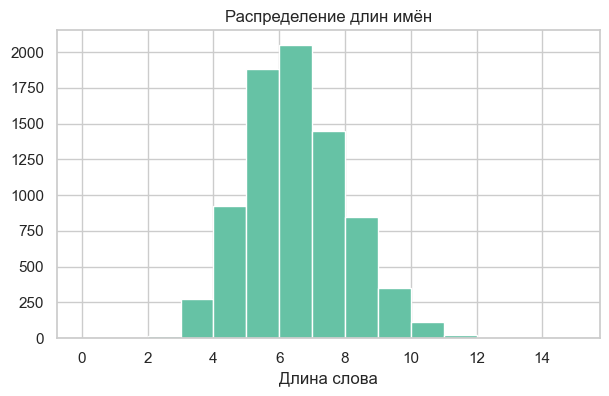

In [8]:
MAX_LENGTH = max(map(len, names))
print("Максимальная длина:", MAX_LENGTH)

plt.figure(figsize=(7, 4))
plt.title("Распределение длин имён")
plt.hist(list(map(len, names)), bins=15, range=(0, 15))
plt.xlabel("Длина слова")
plt.show();

### Предобработка текста

Сеть для генерации текстов должна по текущей последовательности токенов выдавать для всех возможных токенов вероятность быть следующим. Для этого необходимо найти все уникальные токены в обучающих данных.

In [9]:
# запишем в tokens все возможные токены
tokens = set("".join(names))
tokens = list(tokens)

num_tokens = len(tokens)
print("Число токенов:", num_tokens)

Число токенов: 55


In [10]:
print(tokens)

['q', 'R', 'Q', 'x', 'C', 'l', 'E', 'A', 'j', 'g', 'G', 'V', 'O', '-', 'H', 'k', 'J', 'h', 's', 'o', 'L', 'a', 'r', 'X', 'v', 'I', 'i', 'P', 'M', 'm', 'N', 'D', 'K', 'Y', 'B', 't', "'", 'F', 'n', 'w', 'T', 'Z', 'p', 'u', 'y', 'W', 'U', 'd', 'c', 'e', 'f', 'z', 'S', ' ', 'b']


### Перевод символов в целочисленный формат

Сопоставим каждому токену из `tokens` число, чтобы с ним могла работать нейронная сеть.

In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)

{'q': 0, 'R': 1, 'Q': 2, 'x': 3, 'C': 4, 'l': 5, 'E': 6, 'A': 7, 'j': 8, 'g': 9, 'G': 10, 'V': 11, 'O': 12, '-': 13, 'H': 14, 'k': 15, 'J': 16, 'h': 17, 's': 18, 'o': 19, 'L': 20, 'a': 21, 'r': 22, 'X': 23, 'v': 24, 'I': 25, 'i': 26, 'P': 27, 'M': 28, 'm': 29, 'N': 30, 'D': 31, 'K': 32, 'Y': 33, 'B': 34, 't': 35, "'": 36, 'F': 37, 'n': 38, 'w': 39, 'T': 40, 'Z': 41, 'p': 42, 'u': 43, 'y': 44, 'W': 45, 'U': 46, 'd': 47, 'c': 48, 'e': 49, 'f': 50, 'z': 51, 'S': 52, ' ': 53, 'b': 54}


In [12]:
def to_matrix(
    lines, max_len=None, pad=token_to_id[" "], dtype="int32", batch_first=True
):
    """
    Переведём список имён в целочисленную матрицу,
    чтобы с ней могла работать нейросеть
    lines: массив текстов (имён)
    return: матрица, в которой каждая i-ая строка соответствует кодированию i-ого текста.
            Каждому токену соответствует уникальный id.
            Если длина текста меньше максимальной, то кодирование дополняется id токена <pad>,
            если больше максимальной, то кодирование обрезается.
    """

    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i][:max_len]]
        lines_ix[i, : len(line_ix)] = line_ix

    if not batch_first:
        # переведём размерность из [batch, time] в [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

Проверим работу функции.

In [13]:
print("\n".join(names[::2000]))
print(to_matrix(names[::2000]))

Aamir
Pincas
Concettina
Lizette
[[ 7 21 29 26 22 53 53 53 53 53]
 [27 26 38 48 21 18 53 53 53 53]
 [ 4 19 38 48 49 35 35 26 38 21]
 [20 26 51 49 35 35 49 53 53 53]]


### Рекуррентная архитектура для языковой модели

Мы реализуем наиболее простую архитектуру, состоящую из 3 частей:

* эмбеддинг-слой &mdash; `nn.Embedding`;
* рекуррентный слой &mdash; здесь может быть любая рекуррентная сеть (например, Vanilla RNN, LSTM, GRU), в данном случае `nn.LSTM`;
* линейный слой для логитов &mdash; `nn.Linear`.

In [14]:
class CharRNNLoop(nn.Module):
    """Класс модели для генерации имён на основе LSTM"""

    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        # x.shape = (batch_size, max_name_len)
        assert isinstance(x.data, torch.LongTensor)

        # Получим эмбеддинги для входов
        # (batch_size, max_name_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим логиты
        # (batch_size, max_name_len, rnn_num_units)
        h_seq, _ = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logits = self.hid_to_logits(h_seq)

        # Применим log(softmax()) и получим логарифмы вероятностей для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logp = F.log_softmax(next_logits, dim=-1)

        return next_logp

> Заметьте, что здесь мы работаем именно с *логарифмами вероятностей* токенов. То есть преобразуем логиты в $\log p$ с помощью `log_softmax` из `torch.nn.functional` и соответствующий критерий `nn.NLLLoss` (Negative Log-Likelihood Loss), который принимает их на вход. В задаче классификации картинок на прошлом [семинаре](https://miptstats.github.io/courses/ad_fivt/CV_classification.html) мы работали с логитами и критерием `nn.CrossEntropyLoss`.

In [15]:
model = CharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())
history = []

Для примера посчитаем лосс модели на одном батче.

In [17]:
# Преобразуем текст в матричный вид
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

# Получим log вероятностей для токенов
logp_seq = model(batch_ix)

# Посчитаем лосс
loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, num_tokens),
    batch_ix[:, 1:].contiguous().view(-1),
)
print(loss.item())
loss.backward()

4.090948581695557


Обучим модель

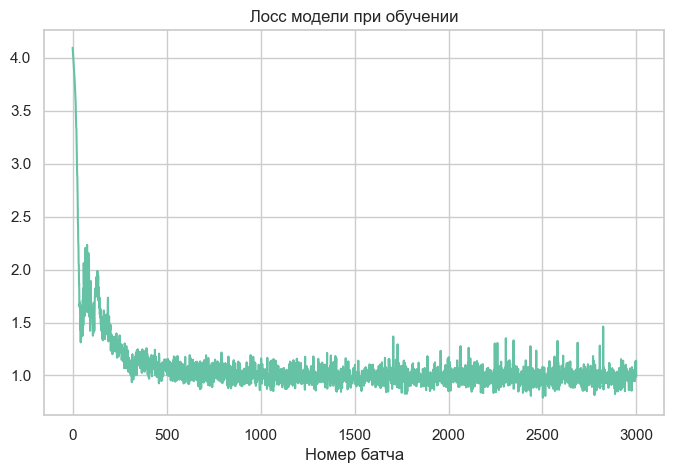

In [18]:
MAX_LENGTH = 16

for i in range(3000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    # Считаем функцию потерь
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # Обратный проход
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.figure(figsize=(8, 5))
        plt.plot(history)
        plt.title("Лосс модели при обучении")
        plt.xlabel("Номер батча")
        plt.show()

In [19]:
def generate_sample(
    rnn_model, seed_phrase=" ", max_length=MAX_LENGTH, temperature=1.0
):
    """
    Функция для генерации имён

    Параметры.
    1) rnn_model — модель, для генерации имён,
    2) seed_phrase — начало имени,
    3) max_length — ограничение на длину слова,
    4) temperature — температура в softmax,
                     позволяет сделать распределение вероятностей более сглаженным и наоборот.
    """

    # Переведем символы в их id
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Цикл генерации по 1 токену
    for _ in range(max_length - len(seed_phrase)):
        # Делаем предсказание моделью, на вход даем всю последовательность
        logp_next = rnn_model(x_sequence)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0, -1]

        # Cэмплируем следующий токен, используя полученные вероятности
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Попробуем сгенерировать какие-нибудь имена.

In [20]:
for _ in range(10):
    print(generate_sample(model, "Vas", max_length=5))

Vashn
Vasan
Vaser
Vasie
Vasra
Vasbe
Vassi
Vasei
Vaslr
Vasnn


**Проблема.** Заметим, что для того, чтобы сгенерировать следующий токен в модель каждый раз подается вся последовательность до текущего токена.

Попробуем написать более умную функцию `forward`, которая принимает не всю последовательность, а только последний выход и скрытое состояние модели.

* Вход:
    * `emb` &mdash; эмбеддинги очередных входных токенов;
    * `(h0, c0)` &mdash; предыдущее скрытое состояние.
    
    
* Выход:
    * `output` &mdash; текущий выход из LSTM слоя;
    * `(h, c)` &mdash; текущее скрытое состояние.


> В случае, если скрытое состояние не подается на вход `forward`, будем обрабатывать последовательность $x$ как ранее.


In [22]:
class SmartCharRNNLoop(nn.Module):
    """Класс модели для генерации имён на основе LSTM,
    которая принимает на вход предыдущее скрытое состояние"""

    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h0=None, c0=None):
        # x.shape = (batch_size, max_name_len)
        assert isinstance(x.data, torch.LongTensor)

        # Получим эмбеддинги для входов
        # (batch_size, max_name_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN сеть, получим логиты и (h, c)
        # output.shape = (batch_size, max_name_len, rnn_num_units)
        if h0 is not None:
            output, (h, c) = self.rnn(emb, (h0, c0))
        else:
            output, (h, c) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logits = self.hid_to_logits(output)

        # Применим log(softmax()) и получим логарифмы вероятностей для каждого токена
        # (batch_size, max_name_len, num_tokens)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, (h, c)

Инициализируем модель и оптимизатор.

In [23]:
model = SmartCharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())
history = []

Обучим улучшенную модель.

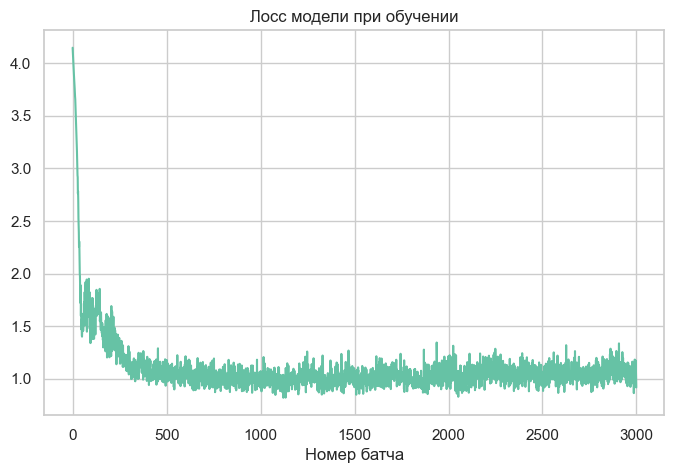

In [24]:
MAX_LENGTH = 16

for i in range(3000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq, _ = model(batch_ix)

    # Считаем функцию потерь
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # Обратный проход
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.figure(figsize=(8, 5))
        plt.plot(history)
        plt.title("Лосс модели при обучении")
        plt.xlabel("Номер батча")
        plt.show()

Напишем более умный метод генерации. На каждом этапе он берет `(h, c)` с предыдущего этапа, а также сгенерированный на предыдущем этапе токен и предсказывает новый токен по полученным из LSTM вероятностям.

In [25]:
def smart_generate_sample(
    rnn_model, seed_phrase=" ", max_length=MAX_LENGTH, temperature=1.0
):
    """
    Функция для генерации имён

    Параметры.
    1) rnn_model — модель для генерации имён
    2) seed_phrase — начало имени
    3) max_length — ограничение на длину слова
    4) temperature — температура в softmax,
                     позволяет сделать распределение вероятностей более сглаженным и наоборот.
    """

    # Переведем символы в их id
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    # Цикл генерации по 1 токену
    for token_id in range(max_length - len(seed_phrase)):
        if token_id == 0:
            logp_next, (h, c) = rnn_model(x_sequence)
        else:
            logp_next, (h, c) = rnn_model(x_sequence[-1:], h, c)
        p_next = F.softmax(
            logp_next[:, -1, :] / temperature, dim=-1
        ).data.numpy()[0, :]

        # Cэмплируем следующий токен, используя полученные вероятности
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [26]:
for _ in range(10):
    print(smart_generate_sample(model, "Vas", max_length=5))

Vasti
Vas  
Vaski
Vaskt
Vast 
Vasto
Vasth
Vasie
Vasth
Vasut


## 3. Задача классификации с использованием рекуррентных нейронных сетей


Посмотрим на то, как можно с помощью рекуррентной нейронной сети решить задачу <a target="_blank" href="https://ru.wikipedia.org/wiki/Анализ_тональности_текста">sentiment analysis</a>.

**Sentiment Analysis** (анализ тональности) — это задача определения эмоциональной окраски текста. Обычно целью является определение тональности текста как положительной, отрицательной или нейтральной.

Пусть 
* $X$ &mdash; набор текстовых данных, где каждый текст представлен в виде последовательности токенов;
* $Y$ &mdash; метки классов, где каждая метка обозначает эмоциональную окраску текста (например, `1` для положительного, `-1` для отрицательного, `0` для нейтрального).

Пусть у нас есть $m$ примеров в наборе данных. Каждый текст представлен в виде последовательности токенов фиксированной длины $n$. Тогда:

- **Входные данные** $X$: Тензор размерности `(m, n)`, где $m$ &mdash; количество примеров, $n$ &mdash; размерность пространства токенов.
- **Метки классов** $Y$: Вектор размерности `(m,)`, где каждый элемент $i$ принимает значения из множества $\{-1, 0, 1\}$.


**Цель**: построить модель $f(X)$, которая по входным текстам $X$ будет предсказывать метки классов $Y$.

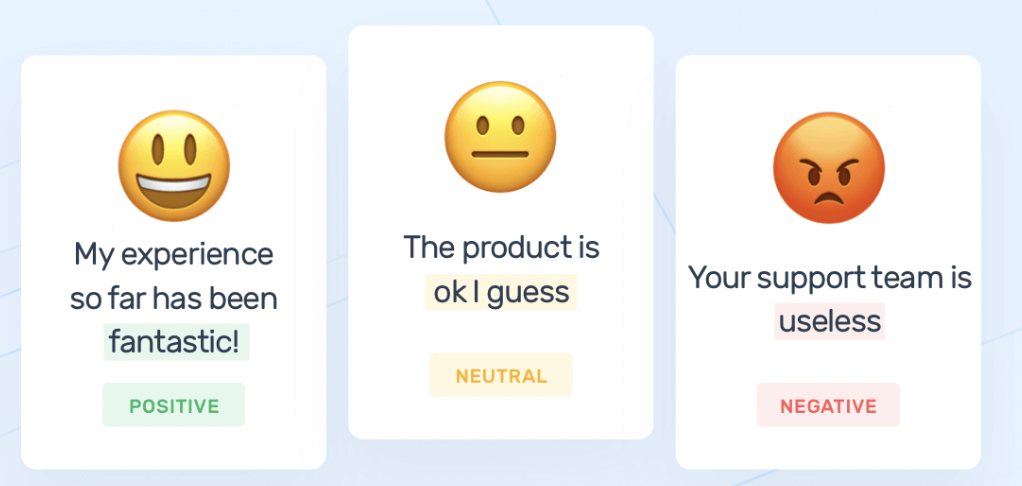

Сейчас для простоты демонстрации будем решать задачу классификации на 2 класса:

* `0` &mdash; негативный отзыв;
* `1` &mdash; позитивный отзыв.


Скачаем датасет отзывов к фильмам с сайта <a target="_blank" href="https://www.imdb.com/">IMDB</a>

In [28]:
train_iter, test_iter = datasets.IMDB()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

Зададим токенизатор, списки стоп-слов и пунктуации.

In [29]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Создадим словарь используемых слов и отфильтруем редко используемые слова.

In [30]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for _, text in train_iter:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Создадим словарь, добавив специальные токены: padding и unknown.

In [31]:
# зададим словарь
import torchtext.vocab

vocab = torchtext.vocab.vocab(ordered_dict)
# vocab = torchtext.v(ordered_dict)

# объявим специальные токены
unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)

C:\Users\Killroy\AppData\Roaming\Python\Python312\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Killroy\AppData\Roaming\Python\Python312\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Немного обсудим возможные стратегии к паддингу последовательностей до одинаковый длины для того, чтобы сформировать входной тензор.

1. Самый простой подход заключается в том, чтобы найти текст с максимальной длиной и дополнить все остальные последовательности до него.


2. Чуть более грамотно сначала сэмплировать батч и уже после этого дополнять паддингом последовательности до максимальной длины в батче.


3. Наиболее продвинутым же является подход, при котором сэмплы приблизительно одинаковый длины группируют в отдельный бакет, а батч примеров сэмплируется из одного бакета.

Подумайте над преимуществами и недостатками каждого подхода. Вторая стратегия проста в реализации и достаточно эффективна, поэтому применяем ее.

In [32]:
class SentimentAnalysisDataset(Dataset):
    """Класс датасета анализа тональности"""

    def __init__(self, texts, labels, smart_pad_collate=False):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.labels = labels

        if smart_pad_collate:
            self.texts.sort(key=len)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

В умном батчинге надо отсортировать тексты, затем разбить их на бакеты. Таким образом в одном бакете тексты будут приблизительно одинаковый длины. Далее при сэмплировании надо сначала выбрать бакет, откуда будем брать, а затем уже индексы семплов внутри бакета. То, что выше &mdash; это обычный паддинг до максимума в батче.

In [33]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до максимальной длины в батче с UNK_IDX
    """
    texts, labels = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]
    labels = torch.LongTensor(labels)

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, labels

Токенизируем текст

In [34]:
train_tokens = [vocab(tokenizer(text)) for _, text in train_dataset]
train_labels = [int(label == 1) for label, _ in train_dataset]

# Разделим все токены и метки на train и test
train_tokens, valid_tokens, train_labels, valid_labels = train_test_split(
    train_tokens, train_labels, stratify=train_labels
)

train_data = SentimentAnalysisDataset(train_tokens, train_labels)
valid_data = SentimentAnalysisDataset(valid_tokens, valid_labels)

Размер получившегося словаря:

In [35]:
num_tokens = len(vocab)
num_tokens

25002

Посмотрим на распределение количества токенов в тексте.

Максимальная длина: 2789


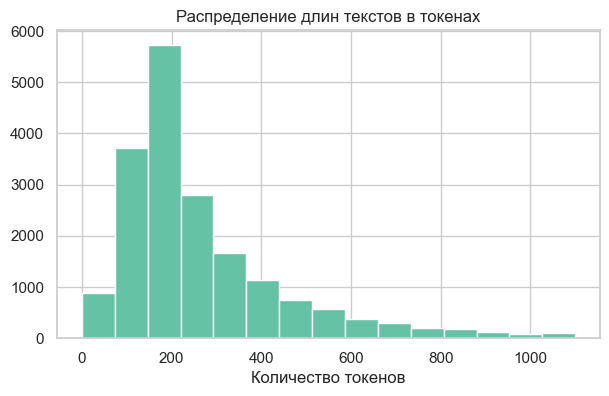

In [36]:
lens = [len(row) for row in train_tokens]
print("Максимальная длина:", max(lens))

plt.figure(figsize=(7, 4))
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.hist(lens, bins=15, range=(0, 1100))
plt.show();

In [37]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

### Архитектура рекуррентной нейронной сети для задачи sentiment analysis

Мы реализуем наиболее простую архитектуру, состоящую из 3 частей:

* эмбеддинг-слой;
* рекуррентный слой &mdash; здесь может быть любая рекуррентная сеть (например, Vanilla RNN, LSTM, GRU);
* линейный слой для предсказания класса.

> В отличие от прошлой модели сейчас мы делаем предсказание класса для всей последовательности, используя последнее скрытое состояние $h_T$.

In [38]:
class SimpleLSTMClassifier(nn.Module):
    """Модель для классификации последовательностей на основе LSTM"""

    def __init__(
        self, num_tokens, emb_size=512, rnn_num_units=64, num_classes=2
    ):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.classifier = nn.Linear(rnn_num_units, num_classes)

    def forward(self, x):
        # x.shape = (batch_size, max_pad_len)

        # Получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        logits = self.classifier(h_state.squeeze(0))
        return logits

Напишем вспомогательные функции для подсчета точности (`binary_accuray`), обучения (`train`) и тестирования (`evaluate`) модели на 1 эпохе. Функция `epoch_time` позволит измерять время прохождения 1 эпохи.

In [39]:
def binary_accuracy(preds, y):
    """
    Возвращает точность модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные метки классов.
    """

    # округляет предсказания до ближайшего integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, loss_history):
    """
    Функция 1 эпохи обучения модели и подсчёта её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, loss_history=None):
    """
    Функция 1 эпохи тестирования модели и подсчёта её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():  # отключим подсчёт градиентов на валидации
        for batch_id, batch in enumerate(iterator):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if loss_history is not None:
                loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Объединим эти функции в единый цикл обучения:

In [40]:
def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(
            model_instance, train_loader, optimizer, criterion, loss_history
        )
        acc_history.append(train_acc)

        # Оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_acc_history.append(valid_acc)

        # Посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Отобразим графики loss'ов
        clear_output(True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title("Train Loss")
        plt.xlabel("Номер батча")
        plt.subplot(1, 3, 2)
        plt.plot(val_loss_history, color="tab:orange")
        plt.title("Valid Loss")
        plt.xlabel("Номер батча")
        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Отрисуем значение точности от эпохи
        plt.subplot(1, 3, 3)
        plt.plot(acc_history, label="Train")
        plt.plot(val_acc_history, label="Valid")
        plt.legend()
        plt.title("Accuracy")
        plt.xlabel("Номер эпохи")
        plt.show()

        print(
            f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
        )

Теперь можем инициализировать модель и обучить ее.

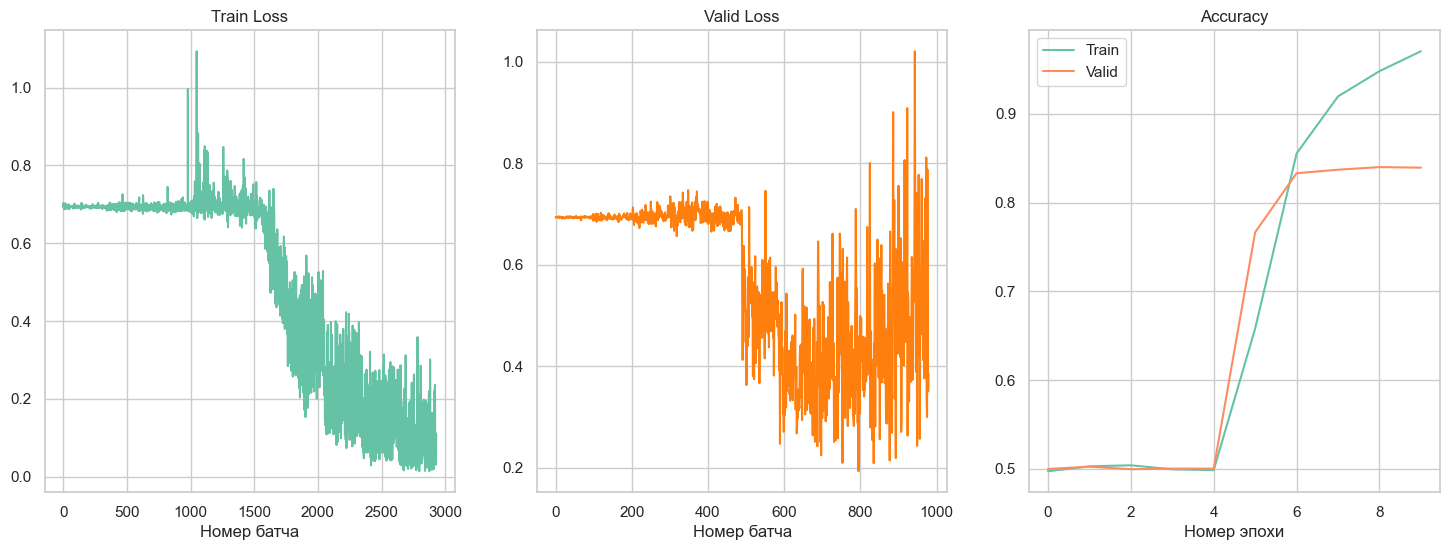

Номер эпохи: 10 | Время обучения эпохи: 0m 40s


In [41]:
model = SimpleLSTMClassifier(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=256,
    num_classes=1,
).to(device)

# У нас задача бинарной классификации, будем использовать BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

training_loop(model)

Посмотрим, что выдает наша модель на конкретных отзывах. Для этого возьмем 1 батч из тестовой выборки.

In [42]:
data_batch, labels_batch = next(iter(valid_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    preds = torch.round(torch.sigmoid(model(data_batch.to(device))))

При генерации батчей мы убирали пунктуацию, поэтому сейчас не сможем посмотреть на изначальный текст. Но суть уловить все еще можно:

In [43]:
label_mapping = ["negative", "positive"]

# Выведем предсказания для 5 случайных примера из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"Predicted label: {label_mapping[int(preds[idx].item())]}")
    print(f"True label: {label_mapping[labels_batch[idx].item()]}")
    print()

Text:
Of reviews I 've read people exceedingly hard Alexandre Neither Marie Veronika ever seemed would particularly desperate keep Alexandre slightly intelligent though intellectual us however hard may anyone admit Alexandre getting away life perfectly totally taken care getting giving wants girls allowing loves sex patron anything wrong anyone love really n't think Though French New Wave cinema prone pretension marvelous simply lack need plot order create emotion perfectly lovely anyone Alexandre 's position urban area ask I 'm looking patron anyone interested
Predicted label: negative
True label: negative

Text:
That song keeps humming head Not greatest song 's 80 's This movie lead singer gets killed accused murders stalks girlfriend sings backup vocals band The lead singer name Billy Eye yeah right dead two years band comes back concert backup lead singer time Billy stalks eventually goes around killing people terrifying girl people around think something wrong imagining things She

**Вывод:** В этом ноутбуке мы научились представлять тексты в численном виде, обучили несколько моделей на основе `nn.LSTM`, генерирующих имена по данному началу. Также научились решать задачу анализа тональности отзывов к фильмам, которая по своей сути является частным случаем задачи классификации текста.
